In [1]:
from IPython.core.display import display, HTML
display(HTML(
    '<style>'
        '.jp-Notebook { padding-left: 0% !important; padding-right: 0% !important; width:100% !important; } '
    '</style>'
))

import pandas as pd
import numpy as np
import os
import re

import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
%matplotlib widget

matplotlib.style.use("bmh")
font = {'size': 13}
matplotlib.rc('font', **font)
# matplotlib.rc('xtick', labelsize=20) 
# matplotlib.rc('ytick', labelsize=20) 

from IPython.display import display

%load_ext autoreload
%autoreload 2
    
import v0_2_0

/tmp/ipykernel_119768/3648520424.py:1: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import display, HTML


In [2]:
COLLECT_TS = "2024-07-30T12:33:54.172726935+00:00"
TARGET_TS = "2024-07-30_14-36-23"
MYSQL_PID = "250468"
JBD2_PID = "718"
PATH = "figures/mysql"
FIGSIZE=(3.2, 3)
os.makedirs(PATH, exist_ok=True)

# Target Metrics

In [3]:
ycsb = pd.read_csv(f"../data/{COLLECT_TS}/application-metrics/ycsb_{TARGET_TS}.samples.csv")
tpcc = pd.read_csv(f"../data/{COLLECT_TS}/application-metrics/tpcc_{TARGET_TS}.samples.csv")

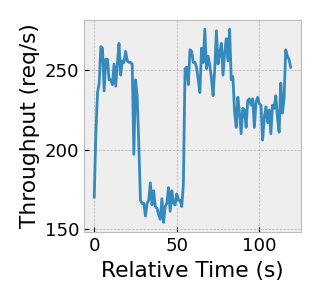

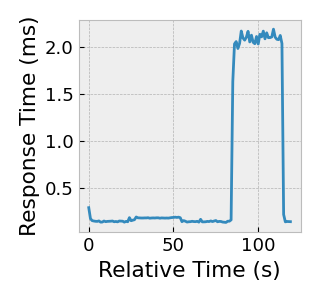

In [171]:
plt.figure(figsize=FIGSIZE)
plt.plot(tpcc["Time (seconds)"], tpcc["Throughput (requests/second)"])
plt.xlabel("Relative Time (s)")
plt.ylabel("Throughput (req/s)")
plt.tight_layout()
plt.savefig(f"{PATH}/target_throughput.pdf", bbox_inches='tight', pad_inches=0)
plt.show()

plt.figure(figsize=FIGSIZE)
plt.plot(ycsb["Time (seconds)"], ycsb["95th Percentile Latency (microseconds)"]/1_000)
plt.xlabel("Relative Time (s)")
plt.ylabel("Response Time (ms)")
plt.tight_layout()
plt.savefig(f"{PATH}/target_percentile.pdf", bbox_inches='tight', pad_inches=0)
plt.show()

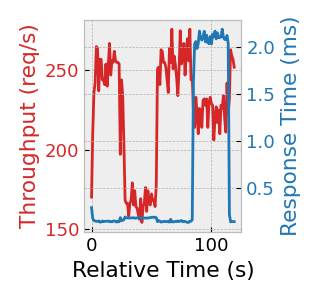

In [122]:
plt.close("all")

COLOR_1, COLOR_2 = "tab:red", "tab:blue"

fig, ax1 = plt.subplots(figsize=FIGSIZE)
ax1.plot(tpcc["Time (seconds)"], tpcc["Throughput (requests/second)"], color=COLOR_1)
ax1.set_xlabel("Relative Time (s)")
ax1.set_ylabel("Throughput (req/s)", color=COLOR_1)
ax1.tick_params(axis='y', labelcolor=COLOR_1)

ax1.tick_params(axis='both')

ax2 = ax1.twinx()
ax2.plot(ycsb["Time (seconds)"], ycsb["95th Percentile Latency (microseconds)"]/1_000, color=COLOR_2)
ax2.set_ylabel("Response Time (ms)", color=COLOR_2)
ax2.tick_params(axis='y', labelcolor=COLOR_2)
ax2.tick_params(axis='both')

# ax1.ticklabel_format(axis='both', style='sci', scilimits=(0,0))
# ax2.ticklabel_format(axis='both', style='sci', scilimits=(0,0))
fig.tight_layout()

plt.savefig(f"{PATH}/target.pdf", bbox_inches='tight', pad_inches=0)

In [5]:
MIN_TIMESTAMP = 1722342863.056538
MAX_TIMESTAMP = ycsb["Time (seconds)"].max() + MIN_TIMESTAMP
MIN_TIMESTAMP, MAX_TIMESTAMP

(1722342863.056538, 1722342982.056538)

# Scenario 1

In this first scenario, we start multiple processes that write data to the same disk used by mysql, causing disk contention. 
Performance should degrade as the share of disk writes belonging to mysql will significantly decrease.

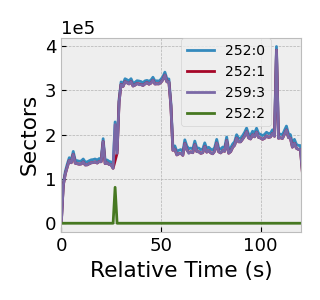

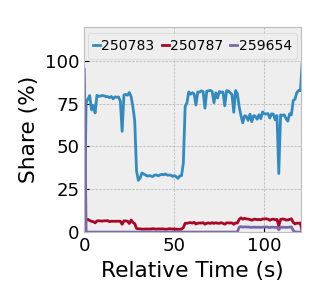

In [130]:
plt.close('all')

XLIM = [0, 60]

metric_files = v0_2_0.recursive_dfs(f"../data/{COLLECT_TS}/system-metrics/global/iowait")
metric_files = pd.Series(metric_files)
metrics = v0_2_0.metric_files_to_df(metric_files)

# Calculate device total

devices = metrics.columns.str.replace(r".*/global_iowait/(\d+)/.*", r"\1", regex=True).unique()
devices = devices[~devices.str.contains("epoch_s")]
device_total = pd.DataFrame()
for device in devices:
    col_filter = col_filter = metrics.columns[metrics.columns.str.contains(f"/{device}/")]
    metrics_device = metrics.loc[:, col_filter]
    device_total[device] = metrics_device.sum(axis=1)

# Plot per thread 

plt.figure(figsize=FIGSIZE)
plt.xlabel("Relative Time (s)")
plt.ylabel("Sectors")
mysql_threads = metrics.columns[metrics.columns.str.contains(MYSQL_PID)]
for col in mysql_threads:
    if col == "epoch_s":
        continue
    # plt.plot(metrics["epoch_s"] - MIN_TIMESTAMP, metrics[col])
    
for device in devices:
    MAJOR, MINOR = int(device) >> 20, int(device) & ((1 << 20) - 1)
    plt.plot(metrics["epoch_s"] - MIN_TIMESTAMP, device_total[device], label=f"{MAJOR}:{MINOR}")
plt.legend(loc=(0.5, 0.545), prop={'size': 10})
plt.xlim([0, 120])
plt.ticklabel_format(axis='y', style='sci', scilimits=(0,0))
plt.tight_layout()
plt.savefig(f"{PATH}/io_device_total.pdf", bbox_inches='tight', pad_inches=0)
plt.show()

plt.figure(figsize=FIGSIZE)
plt.xlabel("Relative Time (s)")
plt.ylabel("Share (%)")
pid_tids = metric_files.str.replace(r".*/iowait/(\d+)/(\d+)/.*", r"\1/\2", regex=True).unique()
pid_tids = ["250468/250783", "250468/250787", "250468/259654"]
for pid_tid in pid_tids:
    for device in ["264241153"]:
        col = f"global/{pid_tid}/global_iowait/{device}/sector_cnt"
        if not metrics.columns.str.contains(col).any():
            continue
        tid = re.search(r"global/\d+/(\d+)/", col).groups()[0]
        plt.plot(metrics["epoch_s"] - MIN_TIMESTAMP, (metrics[col]/device_total[device])*100, label=f"{tid}")
plt.legend(loc="upper center", prop={"size": 10}, ncol=3, handletextpad=0.1, handlelength=0.5, columnspacing=0.5)
plt.xlim([0, 120])
plt.ylim([0, 120])
plt.tight_layout()
plt.savefig(f"{PATH}/io_dev_264241153_threads.pdf", bbox_inches='tight', pad_inches=0)
plt.show()

# Scenario 2

In this scenario, we start another ycsb benchmark that updates some of its rows. The ycsb base benchmark does not perform any writes, and instead is read intensive.

The main consequence of this scenario, would be that there has to be some sort of synchronisation between the read and write intensive ycsb threads. This synchronisation should be one of the causes of increased latency for the ycsb benchmark. 

Unexpectedly, there is another consequence of this behaviour, which is the fact that the ycsb write intensive benchmark also conflicts with the tpcc benchmark. This is caused by the synchronisation that occurs between the 2 benchmark threads when activing the threads that write data to disk.

Thread descriptions:

* Thread 47940 relates to the TPCC benchmark
* Thread 49913 relates to the YCSB update 30s benchmark
* Thread 49329 relates to the YCSB read intensive benchmark

## Scenario 2.1

This scenario refers to the contention that occurs between the two ycsb threads

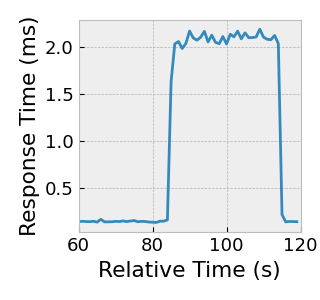

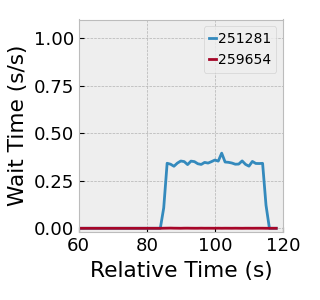

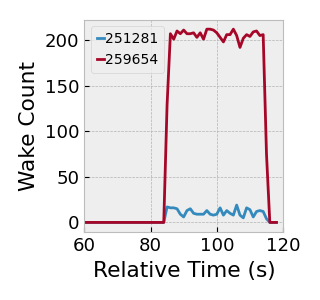

In [10]:
plt.close("all")

XLIM = [60, 120]

plt.figure(figsize=FIGSIZE)
plt.plot(ycsb["Time (seconds)"], ycsb["95th Percentile Latency (microseconds)"]/1_000)
plt.xlabel("Relative Time (s)")
plt.ylabel("Response Time (ms)")
plt.tight_layout()
plt.xlim(XLIM)
plt.savefig(f"{PATH}/database_latency.pdf", bbox_inches='tight', pad_inches=0)
plt.show()

# Wait

metric_files = v0_2_0.recursive_dfs(f"../data/{COLLECT_TS}/system-metrics/thread/{MYSQL_PID}")
metric_files = pd.Series(filter(lambda s: 'futex/wait' in s, metric_files))
plt.figure(figsize=FIGSIZE)
plt.ylabel("Wait Time (s/s)")
plt.xlabel("Relative Time (s)")
for thread in ["251281", "259654"]:
    files = metric_files[metric_files.str.contains(f"{MYSQL_PID}/{thread}/")]
    futexes = files.str.replace(r".*/([\w-]+).csv$", r"\1", regex=True).unique()
    for futex in ["250468-0x76d594012f30"]:#, "250468-0x76d594012f34"]:
        futex_files = files[files.str.contains(f"/{futex}.csv")]
        metrics = v0_2_0.metric_files_to_df(futex_files, epoch_interval_s=(int(MIN_TIMESTAMP), int(MAX_TIMESTAMP)))
        futex_wait_filter = metrics.columns[metrics.columns.str.contains("futex_wait_rate")]
        for col in futex_wait_filter:
            plt.plot(metrics["epoch_s"] - MIN_TIMESTAMP, metrics[col], label=f"{thread}")
plt.xlim(XLIM)
plt.ylim([-0.02, 1.1])
plt.legend(prop={"size": 10}, handletextpad=0.1, handlelength=0.5)
plt.tight_layout()
plt.savefig(f"{PATH}/database_lock_wait.pdf", bbox_inches='tight', pad_inches=0)
plt.show()

# Wake

metric_files = v0_2_0.recursive_dfs(f"../data/{COLLECT_TS}/system-metrics/thread/{MYSQL_PID}")
metric_files = pd.Series(filter(lambda s: 'futex/wake' in s, metric_files))

plt.figure(figsize=FIGSIZE)
plt.ylabel("Wake Count")
plt.xlabel("Relative Time (s)")
threads = metric_files.str.replace(r".*/thread/\d+/(\d+)/.*", r"\1", regex=True).unique()
for thread in ["251281", "259654"]:
    if thread == "260296": 
        continue
    files = metric_files[metric_files.str.contains(f"{MYSQL_PID}/{thread}/")]
    futexes = files.str.replace(r".*/([\w-]+).csv$", r"\1", regex=True).unique()
    for futex in ["250468-0x76d594012f30"]:#, "250468-0x76d594012f34"]:
        futex_files = files[files.str.contains(f"/{futex}.csv")]
        metrics = v0_2_0.metric_files_to_df(futex_files, epoch_interval_s=(int(MIN_TIMESTAMP), int(MAX_TIMESTAMP)))
        futex_wait_filter = metrics.columns[metrics.columns.str.contains("futex_count")]
        for col in futex_wait_filter:
            plt.plot(metrics["epoch_s"] - MIN_TIMESTAMP, metrics[col], label=f"{thread}")
plt.xlim(XLIM)
plt.legend(loc="upper left", prop={"size": 10}, handletextpad=0.1, handlelength=0.5)
plt.tight_layout()
plt.savefig(f"{PATH}/database_lock_wake.pdf", bbox_inches='tight', pad_inches=0)
plt.show()

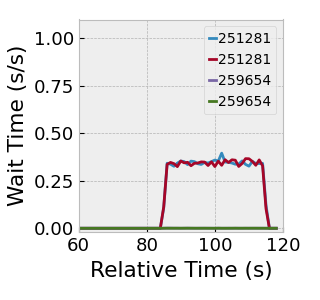

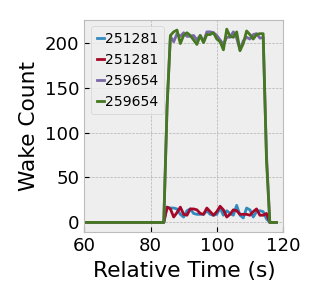

In [11]:
plt.close("all")

XLIM = [60, 120]

# 259654
# 251281
# 260296

# 250468-0x3a6d1e8
# 250468-0x3a6d5e0
# 250468-0x76d594012f30
# 250468-0x76d594012f34

# Wait

metric_files = v0_2_0.recursive_dfs(f"../data/{COLLECT_TS}/system-metrics/thread/{MYSQL_PID}")
metric_files = pd.Series(filter(lambda s: 'futex/wait' in s, metric_files))
plt.figure(figsize=FIGSIZE)
plt.ylabel("Wait Time (s/s)")
plt.xlabel("Relative Time (s)")
for thread in ["251281", "259654"]:
    files = metric_files[metric_files.str.contains(f"{MYSQL_PID}/{thread}/")]
    futexes = files.str.replace(r".*/([\w-]+).csv$", r"\1", regex=True).unique()
    for futex in ["250468-0x76d594012f30", "250468-0x76d594012f34"]:
        futex_files = files[files.str.contains(f"/{futex}.csv")]
        metrics = v0_2_0.metric_files_to_df(futex_files, epoch_interval_s=(int(MIN_TIMESTAMP), int(MAX_TIMESTAMP)))
        futex_wait_filter = metrics.columns[metrics.columns.str.contains("futex_wait_rate")]
        for col in futex_wait_filter:
            plt.plot(metrics["epoch_s"] - MIN_TIMESTAMP, metrics[col], label=f"{thread}")
plt.xlim(XLIM)
plt.ylim([-0.02, 1.1])
plt.legend(prop={"size": 10}, handletextpad=0.1, handlelength=0.5)
plt.tight_layout()
plt.savefig(f"{PATH}/scenario_1_futex_wait.pdf", bbox_inches='tight', pad_inches=0)
plt.show()

# Wake

metric_files = v0_2_0.recursive_dfs(f"../data/{COLLECT_TS}/system-metrics/thread/{MYSQL_PID}")
metric_files = pd.Series(filter(lambda s: 'futex/wake' in s, metric_files))

plt.figure(figsize=FIGSIZE)
plt.ylabel("Wake Count")
plt.xlabel("Relative Time (s)")
threads = metric_files.str.replace(r".*/thread/\d+/(\d+)/.*", r"\1", regex=True).unique()
for thread in ["251281", "259654"]:
    if thread == "260296": 
        continue
    files = metric_files[metric_files.str.contains(f"{MYSQL_PID}/{thread}/")]
    futexes = files.str.replace(r".*/([\w-]+).csv$", r"\1", regex=True).unique()
    for futex in ["250468-0x76d594012f30", "250468-0x76d594012f34"]:
        futex_files = files[files.str.contains(f"/{futex}.csv")]
        metrics = v0_2_0.metric_files_to_df(futex_files, epoch_interval_s=(int(MIN_TIMESTAMP), int(MAX_TIMESTAMP)))
        futex_wait_filter = metrics.columns[metrics.columns.str.contains("futex_count")]
        for col in futex_wait_filter:
            plt.plot(metrics["epoch_s"] - MIN_TIMESTAMP, metrics[col], label=f"{thread}")
plt.xlim(XLIM)
plt.legend(loc="upper left", prop={"size": 10}, handletextpad=0.1, handlelength=0.5)
plt.tight_layout()
plt.savefig(f"{PATH}/scenario_1_futex_wake.pdf", bbox_inches='tight', pad_inches=0)
plt.show()

## Scenario 2.2

This scenario refers to the contention between the ycsb update benchmark and the tpcc benchmark

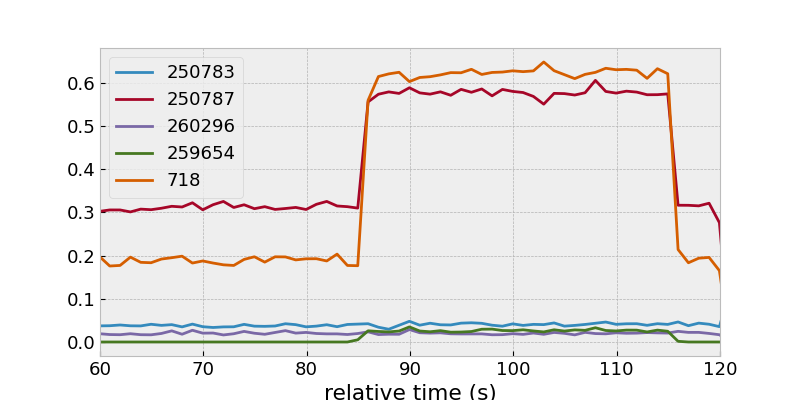

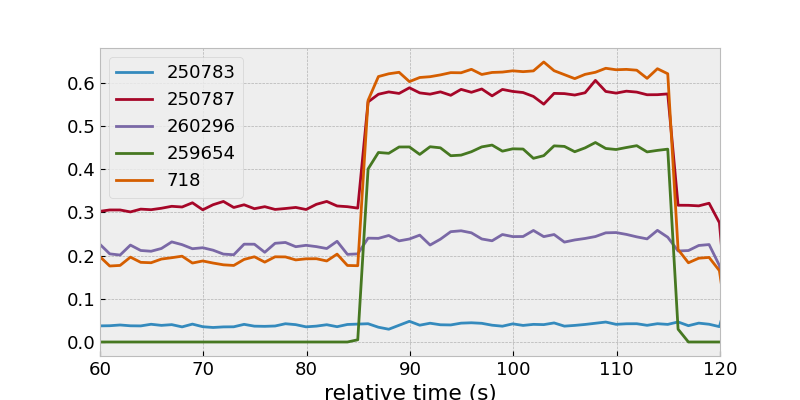

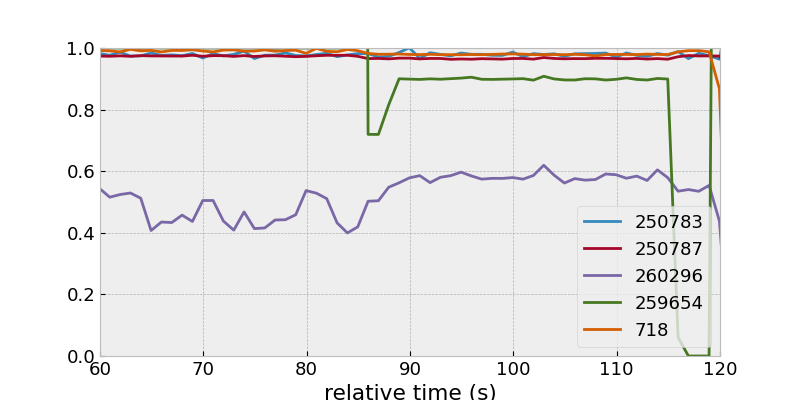

In [133]:
plt.close("all")

XLIM = [60, 120]
# Sched

metric_files = v0_2_0.recursive_dfs(f"../data/{COLLECT_TS}/system-metrics/thread")
metric_files = pd.Series(filter(lambda s: 'sched/' in s, metric_files))

plt.figure(figsize=(8, 4))
plt.xlabel("relative time (s)")
for thread in ["250783", "250787", "260296", "259654", "718"]:
    files = metric_files[metric_files.str.contains(f"/{thread}/")]
    metrics = v0_2_0.metric_files_to_df(files, epoch_interval_s=(int(MIN_TIMESTAMP), int(MAX_TIMESTAMP)))
    col_filter = metrics.columns[metrics.columns.str.contains("iowait_time_rate")]
    for col in col_filter:
        plt.plot(metrics["epoch_s"] - MIN_TIMESTAMP, metrics[col], label=thread)
plt.xlim(XLIM)
plt.legend()
plt.show()

plt.figure(figsize=(8, 4))
plt.xlabel("relative time (s)")
threads = metric_files.str.replace(r".*/thread/\d+/(\d+)/.*", r"\1", regex=True).unique()
for thread in ["250783", "250787", "260296", "259654", "718"]:
    files = metric_files[metric_files.str.contains(f"/{thread}/")]
    metrics = v0_2_0.metric_files_to_df(files, epoch_interval_s=(int(MIN_TIMESTAMP), int(MAX_TIMESTAMP)))
    col_filter = metrics.columns[metrics.columns.str.contains("block_time_rate")]
    for col in col_filter:
        plt.plot(metrics["epoch_s"] - MIN_TIMESTAMP, metrics[col], label=thread)
plt.xlim(XLIM)
plt.legend()
plt.show()

plt.figure(figsize=(8, 4))
plt.xlabel("relative time (s)")
for thread in ["250783", "250787", "260296", "259654", "718"]:
    files = metric_files[metric_files.str.contains(f"/{thread}/")]
    metrics = v0_2_0.metric_files_to_df(files, epoch_interval_s=(int(MIN_TIMESTAMP), int(MAX_TIMESTAMP)))
    col_filter = metrics.columns[metrics.columns.str.contains("sleep_time_rate")]
    for col in col_filter:
        plt.plot(metrics["epoch_s"] - MIN_TIMESTAMP, metrics[col], label=thread)
plt.xlim(XLIM)
plt.ylim([0,1])
plt.legend()
plt.show()

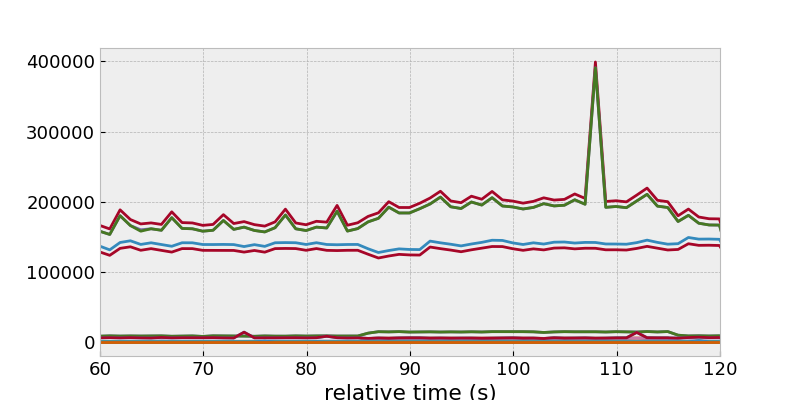

4

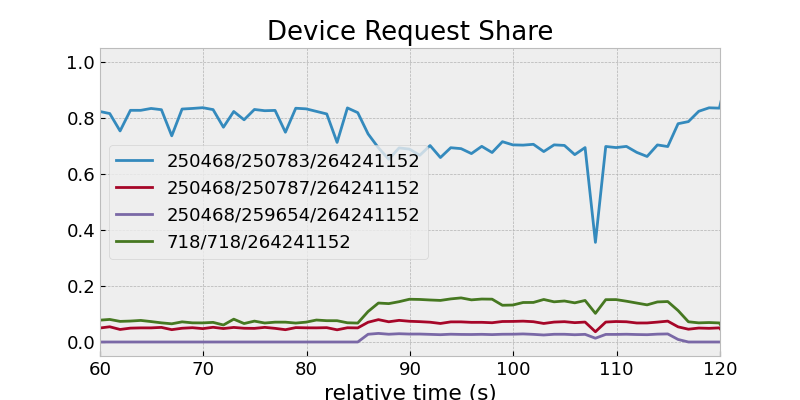

In [134]:
plt.close("all")

XLIM = [60, 120]

metric_files = v0_2_0.recursive_dfs(f"../data/{COLLECT_TS}/system-metrics/global/iowait")
metric_files = pd.Series(metric_files)
metrics = v0_2_0.metric_files_to_df(metric_files)

# Calculate device total

devices = metrics.columns.str.replace(r".*/global_iowait/(\d+)/.*", r"\1", regex=True).unique()
devices = devices[~devices.str.contains("epoch_s")]
device_total = pd.DataFrame()
for device in devices:
    col_filter = col_filter = metrics.columns[metrics.columns.str.contains(f"/{device}/")]
    metrics_device = metrics.loc[:, col_filter]
    device_total[device] = metrics_device.sum(axis=1)

# Plot per thread 

plt.figure(figsize=(8, 4))
plt.xlabel("relative time (s)")
mysql_threads = metrics.columns[metrics.columns.str.contains(MYSQL_PID)]
for col in mysql_threads:
    if col == "epoch_s":
        continue
    plt.plot(metrics["epoch_s"] - MIN_TIMESTAMP, metrics[col])
    
for device in devices:
    plt.plot(metrics["epoch_s"] - MIN_TIMESTAMP, device_total[device])
plt.xlim(XLIM)
plt.show()

plt.figure(figsize=(8, 4))
plt.title("Device Request Share")
plt.xlabel("relative time (s)")
pid_tids = metric_files.str.replace(r".*/iowait/(\d+)/(\d+)/.*", r"\1/\2", regex=True).unique()
pid_tids = ["250468/250783", "250468/250787", "250468/259654", "718/718"]
display(len(pid_tids))
for pid_tid in pid_tids:
    for device in ["264241152"]:
        col = f"global/{pid_tid}/global_iowait/{device}/sector_cnt"
        if not metrics.columns.str.contains(col).any():
            continue
        plt.plot(metrics["epoch_s"] - MIN_TIMESTAMP, metrics[col]/device_total[device], label=f"{pid_tid}/{device}")
plt.legend()
plt.xlim(XLIM)
plt.show()


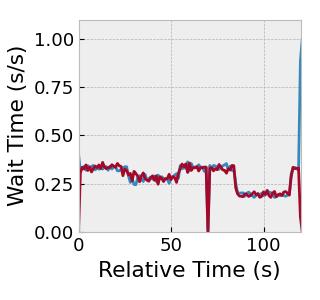

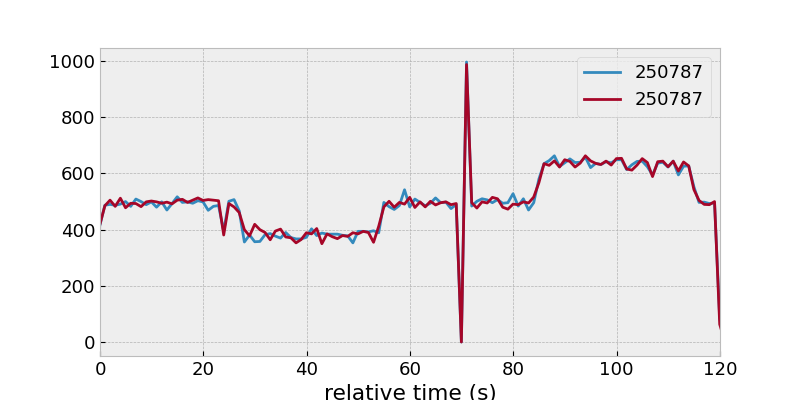

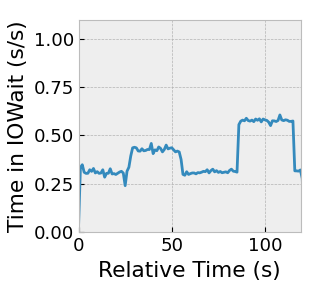

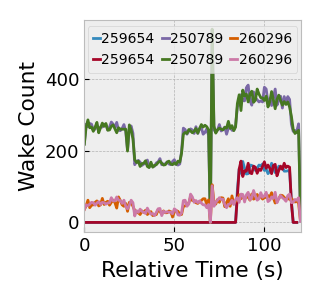

In [172]:
XLIM = [0, 120]

plt.close("all")

# Wait Time

metric_files = v0_2_0.recursive_dfs(f"../data/{COLLECT_TS}/system-metrics/thread/{MYSQL_PID}")
metric_files = pd.Series(filter(lambda s: 'futex/wait' in s, metric_files))
plt.figure(figsize=FIGSIZE)
plt.xlabel("Relative Time (s)")
plt.ylabel("Wait Time (s/s)")
for thread in ["250787"]:
    files = metric_files[metric_files.str.contains(f"{MYSQL_PID}/{thread}/")]
    futexes = files.str.replace(r".*/([\w-]+).csv$", r"\1", regex=True).unique()
    for futex in ["250468-0x76d5fc83c994", "250468-0x76d5fc83c990"]:
        futex_files = files[files.str.contains(f"/{futex}.csv")]
        metrics = v0_2_0.metric_files_to_df(futex_files, epoch_interval_s=(int(MIN_TIMESTAMP), int(MAX_TIMESTAMP)))
        futex_wait_filter = metrics.columns[metrics.columns.str.contains("futex_wait_rate")]
        for col in futex_wait_filter:
            plt.plot(metrics["epoch_s"] - MIN_TIMESTAMP, metrics[col], label=f"{thread}")
plt.xlim(XLIM)
plt.ylim([0, 1.1])
# plt.legend()
plt.tight_layout()
plt.savefig(f"{PATH}/scenario_2_futex_wait.pdf", bbox_inches='tight', pad_inches=0)
plt.show()

# Wait Count

metric_files = v0_2_0.recursive_dfs(f"../data/{COLLECT_TS}/system-metrics/thread/{MYSQL_PID}")
metric_files = pd.Series(filter(lambda s: 'futex/wait' in s, metric_files))
plt.figure(figsize=(8, 4))
plt.xlabel("relative time (s)")
for thread in ["250787"]:
    files = metric_files[metric_files.str.contains(f"{MYSQL_PID}/{thread}/")]
    futexes = files.str.replace(r".*/([\w-]+).csv$", r"\1", regex=True).unique()
    for futex in ["250468-0x76d5fc83c994", "250468-0x76d5fc83c990"]:
        futex_files = files[files.str.contains(f"/{futex}.csv")]
        metrics = v0_2_0.metric_files_to_df(futex_files, epoch_interval_s=(int(MIN_TIMESTAMP), int(MAX_TIMESTAMP)))
        futex_wait_filter = metrics.columns[metrics.columns.str.contains("count")]
        for col in futex_wait_filter:
            plt.plot(metrics["epoch_s"] - MIN_TIMESTAMP, metrics[col], label=f"{thread}")
plt.xlim(XLIM)
plt.legend()
plt.show()

# Sched

metric_files = v0_2_0.recursive_dfs(f"../data/{COLLECT_TS}/system-metrics/thread/{MYSQL_PID}")
metric_files = pd.Series(filter(lambda s: 'sched/' in s, metric_files))

for thread in ["250787"]:
    plt.figure(figsize=FIGSIZE)
    plt.ylabel("Time in IOWait (s/s)")
    plt.xlabel("Relative Time (s)")
    files = metric_files[metric_files.str.contains(f"{MYSQL_PID}/{thread}")]
    metrics = v0_2_0.metric_files_to_df(files, epoch_interval_s=(int(MIN_TIMESTAMP), int(MAX_TIMESTAMP)))
    rate_filter = metrics.columns[metrics.columns.str.contains("iowait_time_rate")].append(pd.Index(["epoch_s"]))
    metrics = metrics.loc[:, rate_filter]
    for col in metrics.columns:
        if col == "epoch_s": 
            continue
        plt.plot(metrics["epoch_s"] - MIN_TIMESTAMP, metrics[col])
    plt.xlim(0, MAX_TIMESTAMP - MIN_TIMESTAMP)
    plt.ylim([0, 1.1])
    plt.tight_layout()
    plt.savefig(f"{PATH}/scenario_2_io_wait.pdf", bbox_inches='tight', pad_inches=0)
    plt.show()

# Wake

metric_files = v0_2_0.recursive_dfs(f"../data/{COLLECT_TS}/system-metrics/thread/{MYSQL_PID}")
metric_files = pd.Series(filter(lambda s: 'futex/wake' in s, metric_files))

plt.figure(figsize=FIGSIZE)
plt.xlabel("Relative Time (s)")
plt.ylabel("Wake Count")
threads = metric_files.str.replace(r".*/thread/\d+/(\d+)/.*", r"\1", regex=True).unique()
for thread in threads:
    if thread not in ["259654", "260296", "250789"]:
        continue
    files = metric_files[metric_files.str.contains(f"{MYSQL_PID}/{thread}/")]
    futexes = files.str.replace(r".*/([\w-]+).csv$", r"\1", regex=True).unique()
    for futex in ["250468-0x76d5fc83c994", "250468-0x76d5fc83c990"]:
        futex_files = files[files.str.contains(f"/{futex}.csv")]
        metrics = v0_2_0.metric_files_to_df(futex_files, epoch_interval_s=(int(MIN_TIMESTAMP), int(MAX_TIMESTAMP)))
        futex_wait_filter = metrics.columns[metrics.columns.str.contains("futex_count")]
        for col in futex_wait_filter:
            plt.plot(metrics["epoch_s"] - MIN_TIMESTAMP, metrics[col], label=f"{thread}")
plt.xlim(XLIM)
plt.legend(loc="upper center", prop={"size": 10}, ncol=3, handletextpad=0.1, handlelength=0.5, columnspacing=0.5)
plt.tight_layout()
plt.savefig(f"{PATH}/scenario_2_futex_wake.pdf", bbox_inches='tight', pad_inches=0)
plt.show()

**Observations**

- Increase in iowait time for thread 250787
- Combination of decrease in time thread 250787 spends waiting for futexes 994 and 990
- Sudden increase in wake-up frequency by thread 259654 (ycsb update) whereas thread 260296's (tpcc) wake up frequency remains approximately constant

## How does thread 250787 impact threads 259654 and 260296

,epoch_s,value
0,1722342863,0.0
1,1722342864,0.0
2,1722342865,0.0
3,1722342866,0.0
4,1722342867,0.0
...,...,...
116,1722342979,0.0
117,1722342980,0.0
118,1722342981,0.0
119,1722342982,0.0


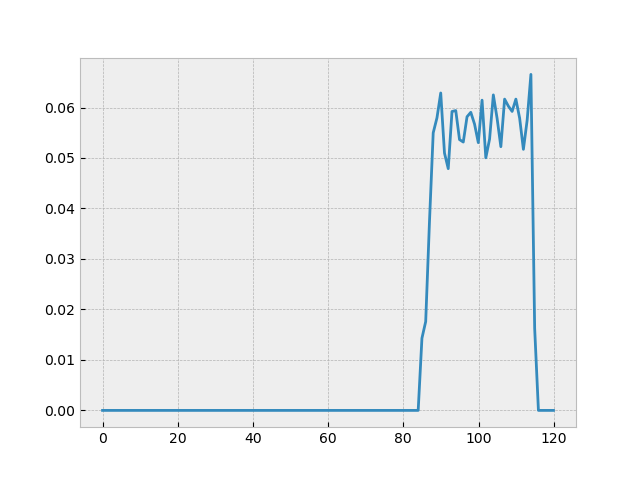

In [102]:
metric_files = v0_2_0.recursive_dfs(f"../data/{COLLECT_TS}/system-metrics/thread/{MYSQL_PID}")
thread_ycsb = pd.Series(filter(lambda s: '259654' in s, metric_files))
futex_wait = thread_ycsb[thread_ycsb.str.contains("futex/wait")]
futexes = futex_wait.str.replace(r".*/([\w-]+).csv$", r"\1", regex=True).unique()

res = pd.Series(dtype="Float64")
res.name = "value"
for futex in futexes:
    wake = pd.Series(filter(lambda s: '250787' in s, metric_files))
    wake = wake[wake.str.contains("futex/wake")]
    wake = wake[wake.str.contains(f"{futex}")]
    if len(wake) == 0: 
        continue
    wake = v0_2_0.metric_files_to_df(wake, epoch_interval_s=(int(MIN_TIMESTAMP), int(MAX_TIMESTAMP)))
    col_filter = wake.columns[wake.columns.str.contains("_count")]
    wake = wake.loc[:, col_filter.append(pd.Index(["epoch_s"]))]
    wake = wake.set_index("epoch_s")
    wake.columns = ["value"]

    wait = futex_wait[futex_wait.str.contains(f"{futex}")]
    wait = v0_2_0.metric_files_to_df(wait, epoch_interval_s=(int(MIN_TIMESTAMP), int(MAX_TIMESTAMP)))
    col_filter = wait.columns[wait.columns.str.contains("_rate")]
    wait = wait.loc[:, col_filter.append(pd.Index(["epoch_s"]))]
    wait = wait.set_index("epoch_s")
    wait.columns = ["value"]

    tmp = wake["value"].mul(wait["value"], fill_value=0)
    res = res.add(tmp, fill_value=0)

res = res.reset_index()
display(res)
plt.figure()
plt.plot(res["epoch_s"] - MIN_TIMESTAMP, res["value"])
plt.show()

,epoch_s,value
0,1722342863,0.0
1,1722342864,0.021834
2,1722342865,0.021641
3,1722342866,0.015151
4,1722342867,0.005025
...,...,...
116,1722342979,0.024669
117,1722342980,0.024778
118,1722342981,0.026089
119,1722342982,0.020271


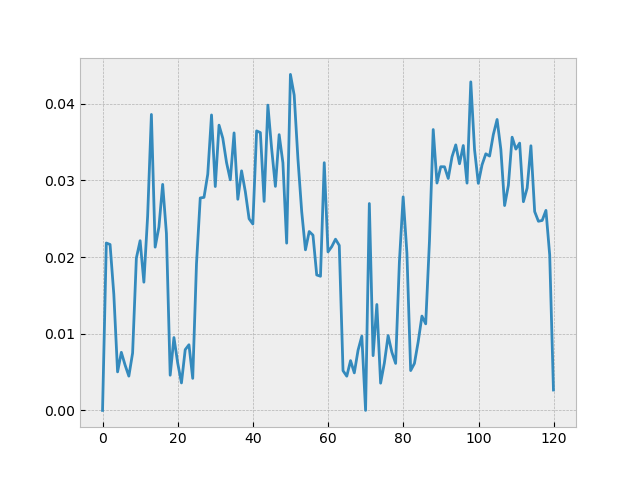

In [103]:
metric_files = v0_2_0.recursive_dfs(f"../data/{COLLECT_TS}/system-metrics/thread/{MYSQL_PID}")
thread_ycsb = pd.Series(filter(lambda s: '260296' in s, metric_files))
futex_wait = thread_ycsb[thread_ycsb.str.contains("futex/wait")]
futexes = futex_wait.str.replace(r".*/([\w-]+).csv$", r"\1", regex=True).unique()

res = pd.Series(dtype="Float64")
res.name = "value"
for futex in futexes:
    wake = pd.Series(filter(lambda s: '250787' in s, metric_files))
    wake = wake[wake.str.contains("futex/wake")]
    wake = wake[wake.str.contains(f"{futex}")]
    if len(wake) == 0: 
        continue
    wake = v0_2_0.metric_files_to_df(wake, epoch_interval_s=(int(MIN_TIMESTAMP), int(MAX_TIMESTAMP)))
    col_filter = wake.columns[wake.columns.str.contains("_count")]
    wake = wake.loc[:, col_filter.append(pd.Index(["epoch_s"]))]
    wake = wake.set_index("epoch_s")
    wake.columns = ["value"]

    wait = futex_wait[futex_wait.str.contains(f"{futex}")]
    wait = v0_2_0.metric_files_to_df(wait, epoch_interval_s=(int(MIN_TIMESTAMP), int(MAX_TIMESTAMP)))
    col_filter = wait.columns[wait.columns.str.contains("_rate")]
    wait = wait.loc[:, col_filter.append(pd.Index(["epoch_s"]))]
    wait = wait.set_index("epoch_s")
    wait.columns = ["value"]

    tmp = wake["value"].mul(wait["value"], fill_value=0)
    res = res.add(tmp, fill_value=0)

res = res.reset_index()
display(res)
plt.figure()
plt.plot(res["epoch_s"] - MIN_TIMESTAMP, res["value"])
plt.show()

In [68]:
metric_files = v0_2_0.recursive_dfs(f"../data/{COLLECT_TS}/system-metrics/thread/{MYSQL_PID}/259654")
metric_files = pd.Series(filter(lambda s: 'futex/wait' in s, metric_files))
wait_futexes = set(metric_files.str.replace(r".*/([\w-]+).csv$", r"\1", regex=True).unique())

metric_files = v0_2_0.recursive_dfs(f"../data/{COLLECT_TS}/system-metrics/thread/{MYSQL_PID}/250787")
metric_files = pd.Series(filter(lambda s: 'futex/wake' in s, metric_files))
wake_futexes = set(metric_files.str.replace(r".*/([\w-]+).csv$", r"\1", regex=True).unique())

intersection = wait_futexes & wake_futexes
display(len(intersection))

3835

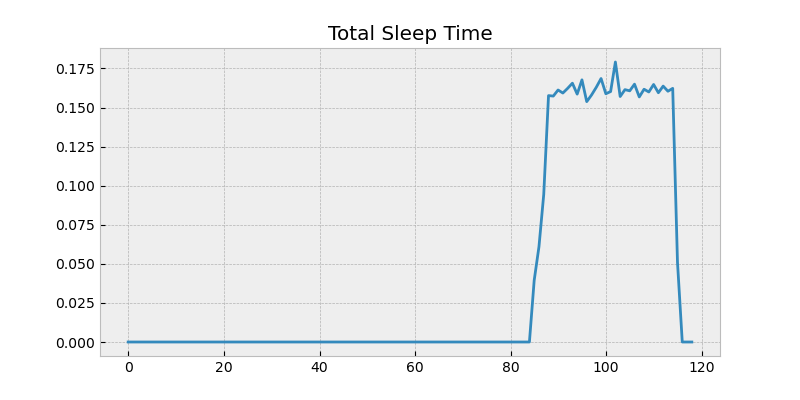

In [40]:
metric_files = v0_2_0.recursive_dfs(f"../data/{COLLECT_TS}/system-metrics/thread/{MYSQL_PID}/259654")
metric_files = pd.Series(filter(lambda s: 'futex/wait' in s, metric_files))

res = pd.Series(dtype="Float64")
res.name = "value"
for futex in intersection:
    futex_files = metric_files[metric_files.str.contains(f"/{futex}.csv")]
    metrics = v0_2_0.metric_files_to_df(futex_files, epoch_interval_s=(int(MIN_TIMESTAMP), int(MAX_TIMESTAMP)))
    futex_wait_filter = metrics.columns[metrics.columns.str.contains("futex_wait_rate")]
    for col in futex_wait_filter:
        sub = metrics.loc[:, ["epoch_s", col]].set_index("epoch_s")
        sub.columns = ["value"]
        res = res.add(sub["value"], fill_value=0)

res = res.reset_index()
plt.figure(figsize=(8, 4))
plt.title("Total Sleep Time")
plt.plot(res["epoch_s"] - MIN_TIMESTAMP, res["value"])
plt.show()

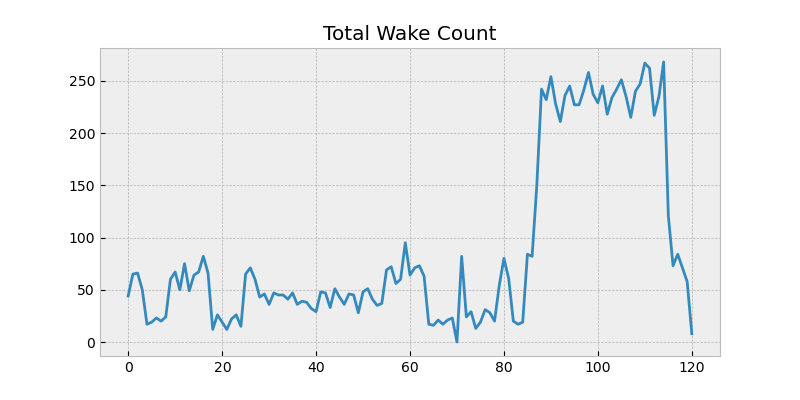

In [39]:
metric_files = v0_2_0.recursive_dfs(f"../data/{COLLECT_TS}/system-metrics/thread/{MYSQL_PID}/250787")
metric_files = pd.Series(filter(lambda s: 'futex/wake' in s, metric_files))

res = pd.Series(dtype="Float64")
res.name = "value"
for futex in intersection:
    futex_files = metric_files[metric_files.str.contains(f"/{futex}.csv")]
    metrics = v0_2_0.metric_files_to_df(futex_files, epoch_interval_s=(int(MIN_TIMESTAMP), int(MAX_TIMESTAMP)))
    futex_wait_filter = metrics.columns[metrics.columns.str.contains("_count")]
    for col in futex_wait_filter:
        sub = metrics.loc[:, ["epoch_s", col]].set_index("epoch_s")
        sub.columns = ["value"]
        res = res.add(sub["value"], fill_value=0)

res = res.reset_index()
plt.figure(figsize=(8, 4))
plt.title("Total Wake Count")
plt.plot(res["epoch_s"] - MIN_TIMESTAMP, res["value"])
plt.show()

In [51]:
metric_files = v0_2_0.recursive_dfs(f"../data/{COLLECT_TS}/system-metrics/thread/{MYSQL_PID}/260296")
metric_files = pd.Series(filter(lambda s: 'futex/wait' in s, metric_files))
wait_futexes = set(metric_files.str.replace(r".*/([\w-]+).csv$", r"\1", regex=True).unique())

metric_files = v0_2_0.recursive_dfs(f"../data/{COLLECT_TS}/system-metrics/thread/{MYSQL_PID}/250787")
metric_files = pd.Series(filter(lambda s: 'futex/wake' in s, metric_files))
wake_futexes = set(metric_files.str.replace(r".*/([\w-]+).csv$", r"\1", regex=True).unique())

intersection = wait_futexes & wake_futexes
display(len(intersection))

3904

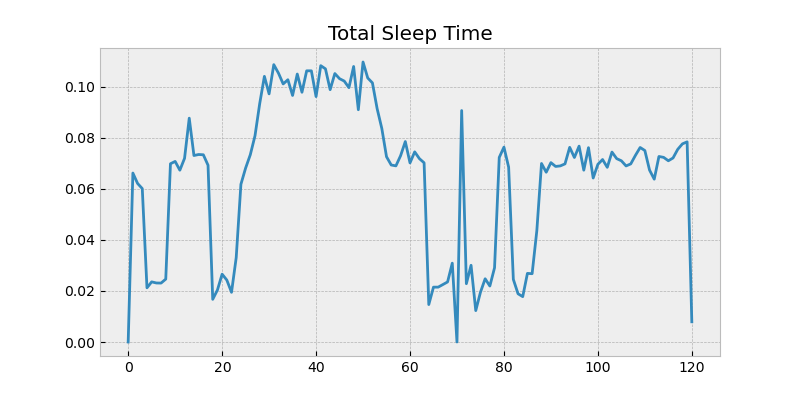

In [45]:
metric_files = v0_2_0.recursive_dfs(f"../data/{COLLECT_TS}/system-metrics/thread/{MYSQL_PID}/260296")
metric_files = pd.Series(filter(lambda s: 'futex/wait' in s, metric_files))

res = pd.Series(dtype="Float64")
res.name = "value"
for futex in intersection:
    futex_files = metric_files[metric_files.str.contains(f"/{futex}.csv")]
    metrics = v0_2_0.metric_files_to_df(futex_files, epoch_interval_s=(int(MIN_TIMESTAMP), int(MAX_TIMESTAMP)))
    futex_wait_filter = metrics.columns[metrics.columns.str.contains("futex_wait_rate")]
    for col in futex_wait_filter:
        sub = metrics.loc[:, ["epoch_s", col]].set_index("epoch_s")
        sub.columns = ["value"]
        res = res.add(sub["value"], fill_value=0)

res = res.reset_index()
plt.figure(figsize=(8, 4))
plt.title("Total Sleep Time")
plt.plot(res["epoch_s"] - MIN_TIMESTAMP, res["value"])
plt.show()

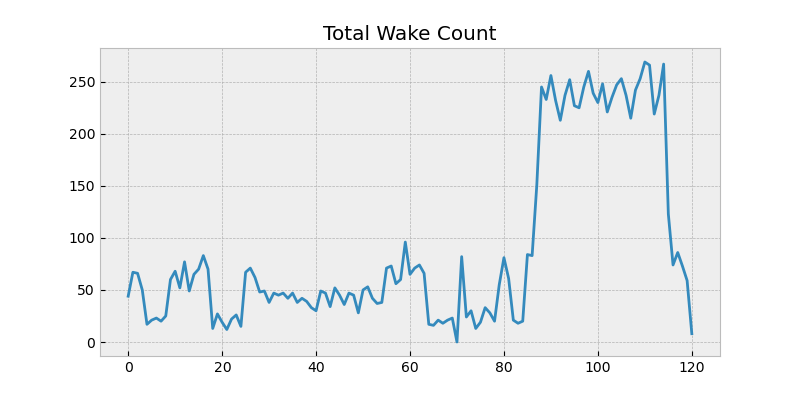

In [46]:
metric_files = v0_2_0.recursive_dfs(f"../data/{COLLECT_TS}/system-metrics/thread/{MYSQL_PID}/250787")
metric_files = pd.Series(filter(lambda s: 'futex/wake' in s, metric_files))

res = pd.Series(dtype="Float64")
res.name = "value"
for futex in intersection:
    futex_files = metric_files[metric_files.str.contains(f"/{futex}.csv")]
    metrics = v0_2_0.metric_files_to_df(futex_files, epoch_interval_s=(int(MIN_TIMESTAMP), int(MAX_TIMESTAMP)))
    futex_wait_filter = metrics.columns[metrics.columns.str.contains("_count")]
    for col in futex_wait_filter:
        sub = metrics.loc[:, ["epoch_s", col]].set_index("epoch_s")
        sub.columns = ["value"]
        res = res.add(sub["value"], fill_value=0)

res = res.reset_index()
plt.figure(figsize=(8, 4))
plt.title("Total Wake Count")
plt.plot(res["epoch_s"] - MIN_TIMESTAMP, res["value"])
plt.show()